# **Homework 2: Hierarchical models & Gibbs sampling**
STAT 348, UChicago, Spring 2025

----------------
**Your name here:**
Zijiang Yang

**Hours spent:**

(Please let us know how many hours in total you spent on this assignment so we can calibrate for future assignments. Your feedback is always welcome!)

----------------

<a href="https://colab.research.google.com/github/aschein/stat_348_2025/blob/main/assignments/hw2/hw2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---

## Instructions

This homework focuses on themes in the first four lectures and will also get you working more with Python and PyTorch.

Assignment is due **Sunday April 13, 11:59pm** on GradeScope.


## Hierarchical model for noisy survey data

We will consider a model for grouped survey data, where there are $n$ respondents in each of $G$ groups. For each respondent $i \in \{1,\dots, n\}$ in each group $g \in\{1,\dots,G\}$, we observe their covariates $\mathbf{x}_{g,i} \in \mathbb{R}^p$ and a scalar summary of their responses $y_{g,i} \in \mathbb{R}$.

We know that some percentage of each group contains respondents who fill out their survey randomly. (This sometimes happens with paid survey work, like on Mechanical Turk.) We don't know for certain whether any individual respondent answered randomly, so we will use a latent variable model to get denoised estimates of regression coefficients, group-specific means, and other quantities.

Consider the following model for noisy grouped survey data. For each respondent $i \in \{1,\dots, n\}$ in each group $g \in\{1,\dots,G\}$, their response is conditionally Gaussian:
$$
\begin{align*}
y_{g,i} &\sim \begin{cases}
\mathcal{N}(\mathbf{x}_{g,i}^\top \boldsymbol{\beta}_g,\, \sigma_g^2) &\textrm{if } z_{g,i} = 1 \\[0.5em]
\mathcal{N}(\mu_0,\, \sigma_0^2) &\textrm{if } z_{g,i} = 0 \\
\end{cases}
\end{align*}
$$
where $z_{g,i} =1$ means that the respondent did not answer randomly and $z_{g,i}=0$ means they did. We don't observe $z_{g,i}$ and treat it as a latent variable:
$$
\begin{align*}
z_{g,i} &\sim \textrm{Bernoulli}(\rho_g) \\
\rho_g &\sim \textrm{Beta}(\alpha_{0,1}, \alpha_{0,2})
\end{align*}
$$
where $\rho_g \in (0,1)$ is the group-specific rate of "good" respondents, for which we assume a conditionally conjugate Beta prior with hyperparameter $\boldsymbol{\alpha}_{0}=[\alpha_{0,1}, \alpha_{0,2}]$. 

We further assume the following conditionally conjugate hierarchical prior over the regression parameters for non-random "good" responses:
$$
\begin{align*}
(\boldsymbol{\beta}_g, \sigma_g^2) &\sim \textrm{NIX}(\textbf{m}, L_0, \nu_0, \tau_0^2) \\
\textbf{m} &\sim \mathcal{N}(0, I)
\end{align*}
$$
We assume that the random responses follow a Gaussian $\mathcal{N}(\mu_0,\, \sigma_0^2)$ whose hyperparameters we know.

The full set of hyperparameters in the model is $\boldsymbol{\eta}_0 = \{\mu_0, \sigma_0^2, \boldsymbol{\alpha}_0, L_0, \nu_0, \tau_0^2\}$.


---

## **Problem 0:** Draw the graphical model [Visual].

Using either sofware (e.g., TikZ, Keynote) or **very neat handwriting**, create a probabilistic graphical model that describes the generative process above. Your PGM should:
- Use plate notation to denote repeated sampling.
- Use shaded circular nodes to denote observed variables.
- Use un-shaded circular nodes to denote latent variables.
- Use square or bullet-nodes to denote hyperparameters.

Include your image in the space below.

---
_Your answer here._
![](graph2.jpg)

---

## Useful distribution objects

For your convenience, we have implemented as `torch.distributions` the `ScaledInvChiSq` and `NIX` distributions below. We will use these distribution objects to implement the generative process in the code below, and you should use them when implementing your Gibbs sampler.

In [2]:
import torch
from torch.distributions import Gamma, TransformedDistribution, MultivariateNormal
from torch.distributions.transforms import PowerTransform

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("notebook")

class ScaledInvChiSq(TransformedDistribution):
    def __init__(self, dof, scale):
        """
        Implementation of the scaled inverse \chi^2 distribution,

        ..math:
            \chi^{-2}(\nu_0, \sigma_0^2)

        It is equivalent to an inverse gamma distribution, which we implement
        as a transformation of a Gamma distribution. Thus, this class inherits
        functions like `log_prob` from its parent.

        Args:
            dof:   degrees of freedom parameter
            scale: scale of the $\chi^{-2}$ distribution.
        """
        base = Gamma(dof / 2, dof * scale / 2)
        transforms = [PowerTransform(-1)]
        TransformedDistribution.__init__(self, base, transforms)
        self.dof = dof
        self.scale = scale

    def sample(self, sample_shape=torch.Size()):
        """
        Generate samples from the scaled inverse chi-squared distribution.

        Args:
            sample_shape: Shape of the samples to generate.

        Returns:
            Samples from the distribution.
        """
        inv_gamma_samples = super().sample(sample_shape)
        return inv_gamma_samples

class NIX:
    def __init__(self, m, L, nu, tausq):
        """
        Implementation of the Normal-Inverse-Chi-Squared (NIX) distribution.

        Args:
            m: mean of the weights (tensor of shape (p,))
            L: precision matrix of the weights (tensor of shape (p, p))
            nu: degrees of freedom (scalar tensor)
            tausq: scale of the variance parameter (scalar tensor)
        """
        self.m = m
        self.L = L
        self.nu = nu
        self.tausq = tausq

    def sample(self, sample_shape=torch.Size()):
        """
        Generate samples from the NIX distribution.

        Args:
            sample_shape: Shape of the samples to generate.

        Returns:
            beta_samples: Samples of the weights (tensor of shape (*sample_shape, p))
            sigmasq_samples: Samples of the variance (tensor of shape (*sample_shape,))
        """
        sigmasq_samples = ScaledInvChiSq(self.nu, self.tausq).sample(sample_shape)
        L_inv = torch.inverse(self.L)
        beta_samples = MultivariateNormal(self.m, sigmasq_samples[..., None, None] * L_inv).sample()
        return beta_samples, sigmasq_samples

## The "forward" sampler

For your convenience, we have also implemented a function to sample from prior (i.e., the "forward" sampler in `sample_state_forward`). This will yield a dictionary of latent variables that we call the model's `state`.

We have also implemented a function to sample from the likelihood in `sample_Y`, which takes in a model `state` and returns a sample from the likelihood. This function relies on another function called `get_likelihood` which returns a `torch.distributions.Normal` object; this function may be useful to you in what you implement, so we recommend you study the code.

The code here also contains examples of how to sample from PyTorch distribution objects without using for-loops (which are very slow in Python), along with examples of indexing, `torch.einsum`, and various other snippets of code that you may find useful.


In [3]:
from torch.distributions import Normal, Beta, Bernoulli

def sample_state_forward(X, hypers):
    """
    Samples the state variables for the forward sampler.

    Args:
        X (torch.Tensor): covariates (groups x respondents x features)
        hypers (dict): dictionary containing the hyperparameters
            - "L_0": torch.Tensor, prior precision matrix of shape (p, p)
            - "nu_0": float, prior degrees of freedom
            - "tausq_0": float, prior scale of variance
            - "alpha": tuple of floats, parameters of the Beta distribution

    Returns:
        dict
            A dictionary containing the sampled state variables:
            - "m_P": torch.Tensor, sampled prior mean of shape (p,)
            - "beta_GP": torch.Tensor, sampled regression coefficients of shape (G, p)
            - "sigmasq_G": torch.Tensor, sampled variances of shape (G,)
            - "rho_G": torch.Tensor, sampled probabilities of shape (G,)
            - "Z_GN": torch.Tensor, sampled binary indicators of shape (G, n)
    """
    G, n, p = X.shape
    m_P = Normal(0, 1).sample((p,))
    beta_GP, sigmasq_G = NIX(m=m_P,
                             L=hypers["L_0"], 
                             nu=hypers["nu_0"], 
                             tausq=hypers["tausq_0"]).sample(sample_shape=(G,))
    
    alpha1, alpha2 = hypers["alpha"]
    rho_G = Beta(alpha1, alpha2).sample((G,))
    Z_GN = Bernoulli(rho_G).sample((n,)).T

    state = {
        "m_P": m_P,
        "beta_GP": beta_GP,
        "sigmasq_G": sigmasq_G,
        "rho_G": rho_G,
        "Z_GN": Z_GN
    }
    return state


def get_likelihood(X, state, hypers):
    """
        Computes the likelihood of the observed data given the current state and hyperparameters.

        Args:
            X (torch.Tensor): covariates (groups x respondents x features)
            state (dict): dictionary containing the current state variables
            hypers (dict): dictionary containing the hyperparameters

        Returns:
            torch.distributions.Normal: A Normal distribution object representing the likelihood
                of the observed data given the current state and hyperparameters.
    """
    G, n, p = X.shape
    mu_0, sigmasq_0 = hypers["mu_0"], hypers["sigmasq_0"]
    beta_GP, sigmasq_G, Z_GN = [state[key] for key in ["beta_GP", "sigmasq_G", "Z_GN"]]

    mu_GN = torch.einsum("gj,gij->gi", beta_GP, X)
    mu_GN[Z_GN == 0] = mu_0

    sigmasq_GN = sigmasq_G.repeat(n, 1).T
    sigmasq_GN[Z_GN == 0] = sigmasq_0
    return Normal(mu_GN, torch.sqrt(sigmasq_GN))


def sample_Y(X, state, hypers):
    """
        Generates synthetic data based on the current state and hyperparameters.

        Args:
            X (torch.Tensor): covariates (groups x respondents x features)
            state (dict): dictionary containing the current state variables
            hypers (dict): dictionary containing the hyperparameters

        Returns:
            torch.Tensor: Y sampled from the likelihood distribution (groups x respondents)
    """
    return get_likelihood(X, state, hypers).sample()

## **Problem 1:** Derive the complete conditionals [Math]

**1a):** Derive the complete conditional distribution $p(z_{g,i} \mid -)$. Here the $-$ notation means "everything", which includes $\textbf{X}$, $\textbf{Y}$, all latent variables other than $z_{g,i}$, and all hyperparameters.

---
Here the $-_{\backslash y_{g,i}}$ notation means "everything" other than $z_{g,i}$ and $y_{g,i}$
$$
\begin{align*}
P(z_{g,i}|y_{g,i},-_{\backslash y_{g,i}})&\propto P(z_{g,i},y_{g,i},-_{\backslash y_{g,i}})\\
&\propto P(y_{g,i}|z_{g,i},-_{\backslash y_{g,i}})P(z_{g,i}|-_{\backslash y_{g,i}})\\
&\propto [N(y_{g,i};x_{g,i}^T\beta_g, \sigma_g^2)\cdot \rho_g]^{z_{g,i}}\cdot [N(y_{g,i};\mu_0,\sigma_0^2)\cdot(1-\rho_g)]^{1-z_{g,i}}
\end{align*}
$$
Therefore, 
$$
z_{g,i}|-\sim Bernoulli(\frac{N(y_{g,i};x_{g,i}^T\beta_g, \sigma_g^2)\cdot \rho_g}{N(y_{g,i};x_{g,i}^T\beta_g, \sigma_g^2)\cdot \rho_g+N(\mu_0,\sigma_0^2)\cdot(1-\rho_g)})\\
P(z_{g,i}|-)=(\frac{N(y_{g,i};x_{g,i}^T\beta_g, \sigma_g^2)\cdot \rho_g}{N(y_{g,i};x_{g,i}^T\beta_g, \sigma_g^2)\cdot \rho_g+N(y_{g,i};\mu_0,\sigma_0^2)\cdot(1-\rho_g)})^{z_{g,i}} \cdot (\frac{N(y_{g,i};\mu_0,\sigma_0^2)\cdot(1-\rho_g)}{N(y_{g,i};x_{g,i}^T\beta_g, \sigma_g^2)\cdot \rho_g+N(y_{g,i};\mu_0,\sigma_0^2)\cdot(1-\rho_g)})^{1-z_{g,i}}
$$

---

**1b):** Derive the complete conditional of $\rho_{g}$.

---

$$
\begin{align*}
P(\rho_g|-) &= P(\rho_g|z_{g,1:n},\alpha_0)\\
&\propto P(z_{g,1:n}|\rho_g,\alpha_0)P(\rho_g|\alpha_0)\\
&\propto \prod_{i=1}^{n} P(z_{g,i}|\rho_g,\alpha_0)P(\rho_g|\alpha_0)\\
&\propto \prod_{i=1}^{n} \rho_g^{z_{g,i}}(1-\rho_g)^{1-z_{g,i}} \rho_g^{\alpha_{0,1}-1}(1-\rho_g)^{\alpha_{0,2}-1}\\
&\propto \rho_g^{\Sigma_{i=1}^{n} z_{g,i}+\alpha_{0,1}-1}\cdot (1-\rho_g)^{n-\Sigma_{i=1}^{n} z_{g,i}+\alpha_{0,2}-1}
\end{align*}
$$
Therefore, 
$$
\begin{align*}
P(\rho_g|-) &=\rho_g^{\Sigma_{i=1}^{n} z_{g,i}+\alpha_{0,1}-1}\cdot (1-\rho_g)^{n-\Sigma_{i=1}^{n} z_{g,i}+\alpha_{0,2}-1}\\
&= Beta(\Sigma_{i=1}^{n} z_{g,i}+\alpha_{0,1},n-\Sigma_{i=1}^{n} z_{g,i}+\alpha_{0,2})
\end{align*}
$$
---

**1c):** Derive the complete conditional of $(\boldsymbol{\beta}_g, \sigma_g^2)$.

---
Denote $\mathcal{I}_g$={ indexes of i where $z_{g,i}=1$ }, $X_g$ is the matrix of $x_{g,i}$, $Y_g$ is the vector of $y_{g,i}$, whose corresponding $z_{g,i}$ must be 1.

Let 
$$
\begin{align*}
L_n&=L_0+X_g^TX_g,\\
m_n&=L_n^{-1}(L_0m+X_g^TY_g),\\
v_n&=v_0+|\mathcal{I}_g|,\\
\tau_n^2&=\frac{1}{v_n}[v_0\tau_0^2+Y_g^TY_g+m^TL_0m-m_n^TL_nm_n]
\end{align*}
$$

$$
\begin{align*}
P(\beta_g,\sigma_g^2|-) &\propto P(y_{g,\mathcal{I}_g}|\beta_g,\sigma_g^2,x_{g,\mathcal{I}_g})P(\beta_g,\sigma_g^2|m,L_0,v_0,\tau_0^2)\\
&\propto \prod_{\mathcal{I}_g} \frac{1}{\sqrt{2\pi\sigma_g^2}}e^{-\frac{(y_{g,i}-x_{g,i}^T\beta_g)^2}{2\sigma_g^2}}\cdot (\sigma_g^2)^{-(v_0/2+1)}e^{-\frac{v_0\tau_0^2}{2\sigma_g^2}}\cdot \frac{1}{\sqrt{2\pi\sigma_g^2L_0^{-1}}}e^{-\frac{1}{2\sigma_g^2}(\beta_g-m)^TL_0(\beta_g-m)}\\
&\propto (\sigma_g^2)^{-(\frac{|\mathcal{I}_g|+v_0}{2}+1)} (\sigma_g^2)^{-\frac{p}{2}}exp(-\frac{Y_g^TY_g-2Y_g^TX_g\beta_g+\beta_g^TX_g^TX_g\beta_g+(\beta_g-m)^TL_0(\beta_g-m)+v_0\tau_0^2}{2\sigma_g^2})\\
&\propto (\sigma_g^2)^{-(\frac{v_n}{2}+1)}exp(-\frac{v_n\tau_n^2}{2\sigma_g^2})(\sigma_g^2)^{-\frac{p}{2}}exp(-\frac{1}{2\sigma_g^2}(\beta_g-m_n)^TL_n(\beta_g-m_n))\\
&\propto NIX(m_n,L_n,v_n,\tau_n^2)
\end{align*}
$$


---

**1d):** Derive the complete conditional of $\textbf{m}$.

---
Let
$$
\begin{align*}
\Sigma_G &=(\sum_{g=1}^G\frac{L_0}{\sigma_g^2}+I)^{-1}\\
\mu_G &= \Sigma_G(\sum_{g=1}^G \frac{L_0\beta_g}{\sigma_g^2})
\end{align*}
$$

Therefore, we can derive the complete condition of m.

$$
\begin{align*}
P(m|-) &\propto P(\beta_{1:G}|-)P(m|-_{\backslash \beta_{1:G}})\\
&\propto \prod_{g=1}^G N(\beta_g;m,\sigma_g^2L_0^{-1}) \cdot N(m|0,1)\\
&\propto \prod_{g=1}^G exp(-\frac{1}{2\sigma_g^2}(\beta_g-m)^TL_0(\beta_g-m))\cdot exp(-m^Tm/2)\\
&\propto exp(-\frac{1}{2}[\sum_{g=1}^G(\frac{m^TL_0m}{\sigma_g^2}-2\frac{m^TL_0\beta_g}{\sigma_g^2}+\frac{\beta_g^T\beta_g}{\sigma_g^2})+m^Tm])\\
&\propto exp(-\frac{1}{2}(m-\mu_G)^T\Sigma_G^{-1}(m-\mu_G))\\
&\propto N(m;\mu_G,\Sigma_G)
\end{align*}
$$


---

## **Problem 2:** Implement the complete conditionals [Code]

**2a):** Implement the complete conditional of $z_{g,i}$.

For this, you should make sure your implementation is numerically stable by computing things in log-space using the **logsumexp trick**. You can read about the math of the logsumexp trick [here]((https://gregorygundersen.com/blog/2020/02/09/log-sum-exp/)). Your implementation should involve `torch.logsumexp` which you can read about [here](https://pytorch.org/docs/stable/generated/torch.logsumexp.html).

In [4]:
def update_Z_GN(Y, X, state, hypers):
    """
    Update the binary latent variable Z_GN based on the current state, data, 
    and hyperparameters. This function should compute the log-probabilities for 
    Z_GN being 0 vs 1, normalizes them in log-space to log-probabilities, and then 
    samples new values for Z_GN from the resulting Bernoulli distribution.

    Args:
        Y (torch.Tensor): Observed responses (groups x respondents).
        X (torch.Tensor): Covariates (groups x respondents x features).
        state (dict): Current state of the model containing latent variables.
        hypers (dict): Dictionary of hyperparameters.

        NOTE: By default, we pass (Y, X, state, hypers) to all complete conditionals,
        however certain complete conditionals may not require some of these inputs.

    Returns:
        None: Updates the 'Z_GN' key in the state dictionary in-place.
    
    """
    from torch.distributions import Normal
    beta_GP = state['beta_GP']
    sigmasq_G = state['sigmasq_G']
    rho_G = state['rho_G']
    mu_0 = hypers['mu_0']
    sigmasq_0 = hypers['sigmasq_0']
    GX = torch.einsum('gnp,gp->gn', X, beta_GP)
    dist_1 = Normal(loc=GX, scale=sigmasq_G.sqrt().unsqueeze(1))  # G x N
    log_p1 = torch.log(rho_G).unsqueeze(1) + dist_1.log_prob(Y)
    dist_0 = Normal(loc=mu_0, scale=sigmasq_0 ** 0.5)
    log_p0 = torch.log(1 - rho_G).unsqueeze(1) + dist_0.log_prob(Y)
    log_p = torch.stack([log_p0, log_p1], dim=-1)  # shape: G x N x 2
    log_p_norm = log_p - torch.logsumexp(log_p, dim=-1, keepdim=True)
    log_p_GN = log_p_norm[..., 1]

    p_GN = torch.exp(log_p_GN)
    assert torch.isfinite(p_GN).all()
    state['Z_GN'] = Bernoulli(p_GN).sample()

**2b):** Implement the complete conditional of $\rho_{g}$.

In [5]:
def update_rho_G(Y, X, state, hypers):
    """ Update the probabilities rho_G based on the current state, data, 
    and hyperparameters. 

    Args:
        Y (torch.Tensor): Observed responses (groups x respondents).
        X (torch.Tensor): Covariates (groups x respondents x features).
        state (dict): Current state of the model containing latent variables.
        hypers (dict): Dictionary of hyperparameters containing:

    Returns:
        None: Updates the 'rho_G' key in the state dictionary in-place.
    """
    Z_GN = state['Z_GN']
    alpha_1 = hypers['alpha'][0]
    alpha_2 = hypers['alpha'][1]

    count_1 = Z_GN.sum(dim=1) 
    count_0 = Z_GN.shape[1] - count_1

    new_alpha_1 = alpha_1 + count_1
    new_alpha_2 = alpha_2 + count_0

    rho_G = Beta(new_alpha_1, new_alpha_2).sample()

    state['rho_G'] = rho_G

**2c):** Implement the complete conditional of $(\boldsymbol{\beta}_g, \sigma_g^2)$.

**Hint:** you have derivations and code from HW1 that you could re-use.

In [6]:
def update_regression_params(Y, X, state, hypers):
    """ Update the regression parameters based on the current state, data, 
    and hyperparameters. 

    Args:
        Y (torch.Tensor): Observed responses (groups x respondents).
        X (torch.Tensor): Covariates (groups x respondents x features).
        state (dict): Current state of the model containing latent variables.
        hypers (dict): Dictionary of hyperparameters containing:

    Returns:
        None: Updates the 'beta_GP' and `sigmasq_G' keys in the state dictionary in-place.
    """
    Z_GN = state['Z_GN']            # shape: (G, N)
    L_0 = hypers["L_0"]             # shape: (P, P)
    nu_0 = hypers["nu_0"]           # scalar
    tausq_0 = hypers["tausq_0"]     # scalar
    #m_0 = hypers["m_0"]             # shape: (P,)
    m_P= state['m_P'] 

    G, N, P = X.shape
    beta_list = []
    sigmasq_list = []

    for g in range(G):
        z_g = Z_GN[g]               # shape: (N,)
        x_g = X[g][z_g == 1]        # shape: (M, P)
        y_g = Y[g][z_g == 1]        # shape: (M,)

        M = x_g.shape[0]
        if M == 0:
            beta_g, sigma2_g = NIX(m_P,L_0,nu_0,tausq_0).sample()
            beta_list.append(beta_g)
            sigmasq_list.append(sigma2_g)
            continue

        L_n = x_g.T @ x_g + L_0 
        m_n = torch.linalg.solve(L_n, x_g.T @ y_g + L_0 @ m_P)
        nu_n = nu_0 + M
        tausq_n = (nu_0 * tausq_0 - m_n @ L_n @ m_n + y_g @ y_g + m_P @ L_0 @ m_P ) / nu_n

        beta_g, sigma2_g = NIX(m_n,L_n,nu_n,tausq_n).sample()
        beta_list.append(beta_g)
        sigmasq_list.append(sigma2_g)

    state['beta_GP'] = torch.stack(beta_list)
    state['sigmasq_G'] = torch.stack(sigmasq_list)
    

**2d):** Implement the complete conditional of $\textbf{m}$.


In [7]:
def update_m_P(Y, X, state, hypers):
    """ Update the mean of regression coefficients m_P based on the current state, data, 
    and hyperparameters. 

    Args:
        Y (torch.Tensor): Observed responses (groups x respondents).
        X (torch.Tensor): Covariates (groups x respondents x features).
        state (dict): Current state of the model containing latent variables.
        hypers (dict): Dictionary of hyperparameters containing:

    Returns:
        None: Updates the 'm_P' key in the state dictionary in-place.
    """
    L_0 = hypers["L_0"]
    sigmasq_G = state["sigmasq_G"]
    beta_GP = state['beta_GP']
    G, P = beta_GP.shape


    I = torch.eye(P)

    cov_inv = L_0 *sum(1/sigmasq_G)+ I
    cov_n = torch.linalg.inv(cov_inv)  # shape: (P, P)

    # μ_G = Σ_G * sum_g (L_0 * beta_g / sigmasq_g)
    sum_term = sum((L_0 @ beta_GP[g]) / sigmasq_G[g] for g in range(G))  # shape: (P,)
    mu_G = cov_n @ sum_term  # shape: (P,)

    m_P = torch.distributions.MultivariateNormal(mu_G, cov_n).sample()

    state['m_P'] = m_P

## Gibbs sampler

For your convenience, we have implemented the function `gibbs` which relies on the complete conditionals you implemented in problem 2.

In [8]:
from copy import deepcopy
from tqdm import tqdm

def get_gibbs_transition(Y, X, hypers):
    """Returns a function that performs a single Gibbs transition
    
    Args:
        Y (torch tensor): responses (groups x respondents)
        X (torch tensor): covariates (groups x respondents x features)
        hypers (dict): dictionary containing the hyperparameters
    
    Returns:
        function: function that performs a single Gibbs transition
    """
    def gibbs_transition(state):
        update_Z_GN(Y, X, state, hypers)
        # print(state['Z_GN'])
        update_rho_G(Y, X, state, hypers)
        # print(state['rho_G'])
        update_regression_params(Y, X, state, hypers)
        # print(state['beta_GP'] ,state['sigmasq_G'])
        update_m_P(Y, X, state, hypers)
        # print(state['m_P'])
        return state

    return gibbs_transition


def gibbs(Y, X, hypers, n_samples=250, n_burnin=100, n_thin=5):
    """Gibbs sampler

    Args:
        Y (torch tensor): responses (groups x respondents)
        X (torch tensor): covariates (groups x respondents x features)
        hypers (dict): dictionary containing the hyperparameters
        n_samples (int, optional): number of posterior samples to collect. 
        n_burnin (int, optional): number of burn-in samples.
        n_thin (int, optional): thinning parameter. Only collect every n_thin samples.
    
    Returns:
        posterior_samples (list): list of posterior samples, each sample is a state dictionary
    """
    # initialize the state from the prior
    state = sample_state_forward(X, hypers)
    
    # get the transition operator
    gibbs_transition = get_gibbs_transition(Y, X, hypers)

    # burn-in samples
    for _ in tqdm(range(n_burnin)):
        state = gibbs_transition(state)
    
    posterior_samples = []
    for m in tqdm(range(n_samples * n_thin)):
        state = gibbs_transition(state)

        # only collect every n_thin samples
        if m % n_thin == 0:
            # make sure to deepcopy so the code does not modify the collected states
            posterior_samples.append(deepcopy(state)) 
    
    return posterior_samples  

## **Problem 3:** Geweke testing [Code, results]

In this problem you will implement and run a Geweke test to ensure your Gibbs sampler is correctly derived and implemented.

See the lecture notes, along with [Grosse & Duvenaud (2014)](https://arxiv.org/pdf/1412.5218.pdf) and [Geweke (2004)](https://www.jstor.org/stable/27590449) for details on Geweke testing.

In general, a Geweke test compares two sets of samples which should both be iid from the joint distribution $p(\textbf{Y}, \textbf{Z})$ of data $\textbf{Y}$ and latent variables $\textbf{Z}$ (note here $\textbf{Z}$ means **all** latent variables in a model). The first set of samples are the **forward samples** ($\textbf{Y}_m^f$, $\textbf{Z}_m^f)_{m=1}^M$ which are drawn iid:
$$\begin{align*}
\textbf{Z}_m^f &\sim p(\textbf{Z}) & \textrm{prior} \\
\textbf{Y}_m^f &\sim p(\textbf{Y} \mid \textbf{Z}_m^f) &\textrm{likelihood}
\end{align*}
$$
The second set of samples are the **backward samples** ($\textbf{Y}_m^b$, $\textbf{Z}_m^b)_{m=1}^M$ which are drawn using Gibbs sampling:
$$\begin{align*}
\textbf{Z}_m^b &\sim \pi(\textbf{Z} \mid \textbf{Z}_{m-1}^b, \textbf{Y}_{m-1}^f)  & \textrm{Gibbs transition kernel}\\
\textbf{Y}_m^b &\sim p(\textbf{Y} \mid \textbf{Z}_m^b) & \textrm{likelihood}
\end{align*}
$$

**3a):** Finish implementing `geweke_test` below by implementing the backward sampler. The backward sampler should:
- First, initialize all latent variables and data with a draw from the prior / likelihood (i.e., using a forward sample).

- Then, it should run 10,000 iterations of burn-in, and then another 50,000 iterations, saving every 5th sample. The output should be 10,000 samples, each of which is a dictionary containing latent variables **and data**.

- Make sure that your backward sampler is indeed generating samples from the joint distribution.

In [9]:
def geweke_test(X, hypers, n_samples=10000, n_burnin=10000, n_thin=5):
    """Geweke test
    
    Args:
        X (torch tensor): covariates (groups x respondents x features)
        hypers (dict): dictionary containing the hyperparameters
        n_samples (int, optional): number of forward and backward samples to collect.
        n_burnin (int, optional): number of burn-in samples.
        n_thin (int, optional): thinning parameter. Only collect every n_thin samples.
    
    Returns:
        forward_samples (list): list of forward samples, each sample is a state dictionary
        backward_samples (list): list of backward samples, each sample is a state dictionary
    
    References:
        [1] Grosse & Duvenaud (2014) "Testing MCMC Code": https://arxiv.org/pdf/1412.5218.pdf
        [2] Geweke (2004) "Getting it right...": https://www.jstor.org/stable/27590449
    """

    # sample forward from the prior and likelihood
    forward_samples = []
    forward_Y = []
    for _ in tqdm(range(n_samples)):
        state = sample_state_forward(X, hypers)
        state['Y'] = sample_Y(X, state, hypers)
        forward_samples.append(deepcopy(state)) 
        forward_Y.append(state['Y']) 

    backward_samples = []
    state = sample_state_forward(X, hypers)
    state['Y'] = sample_Y(X, state, hypers)
    for _ in tqdm(range(n_burnin)):
        gibbs_transition = get_gibbs_transition(state['Y'], X, hypers)
        state = gibbs_transition(state)
        state['Y'] = sample_Y(X, state, hypers)
 
    for m in tqdm(range(n_samples * n_thin)):
        gibbs_transition = get_gibbs_transition(state['Y'], X, hypers)
        state = gibbs_transition(state)
        state['Y'] = sample_Y(X, state, hypers)

        # only collect every n_thin samples
        if m % n_thin == 0:
            # make sure to deepcopy so the code does not modify the collected states
            backward_samples.append(deepcopy(state))  
    return forward_samples, backward_samples

**3b):** Now run the cell below to Geweke test your code. The output should be two PP-plots that compare the means $\rho_g$ and $\mathbf{m}$ between the forward and backward sample. The PP-plots should be **straight along the diagonal**; if they are not straight, there is a bug in the derivation or code (or both) of your Gibbs sampler. For reference, running this took our implementation 3 minutes; if it is much slower for you, you should investigate the bottlenecks in your code.

  2%|▏         | 171/10000 [00:00<00:35, 277.10it/s]

100%|██████████| 50000/50000 [06:25<00:00, 129.55it/s]


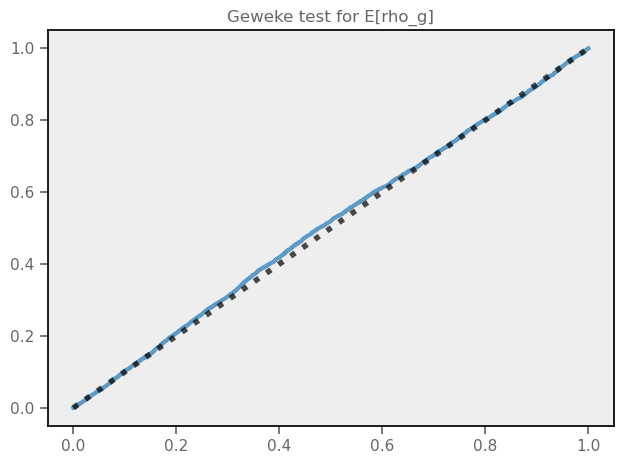

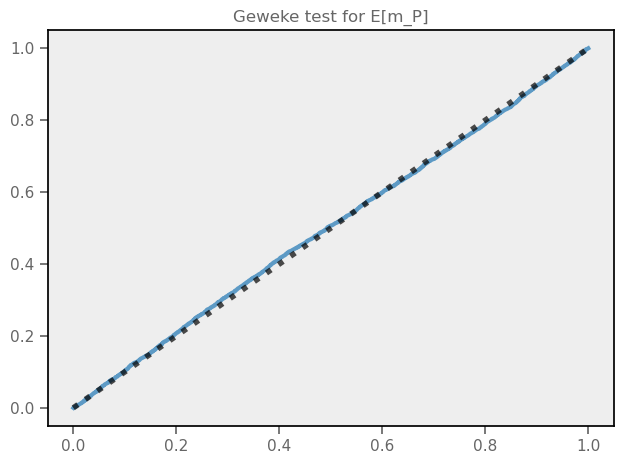

<Figure size 640x480 with 0 Axes>

In [10]:
from pp_plot import pp_plot

# You can/should use small G, p, n for the purposes of testing to speed up the code
# Theoretically, your code should pass the Geweke test for any setting of hyperparams.
G = 3
p = 2
n = 10

X = Normal(0, 0.1).sample((G, n, p))
X[:, :, 0] = 1.0

hypers = {"m_0": torch.zeros(p),
          "L_0": torch.eye(p) * 1,
          "nu_0": 1.0,
          "tausq_0": 0.1,
          "alpha": torch.Tensor([5., 1.]),
          "mu_0": -1.0,
          "sigmasq_0": 2.0}

forward_samples, backward_samples = geweke_test(X=X, 
                                                hypers=hypers, 
                                                n_samples=10000, 
                                                n_burnin=10000, 
                                                n_thin=5)

# Compare the arithmetic mean of the rho_G parameters across samples
arr1 = [state['rho_G'].mean() for state in forward_samples]
arr2 = [state['rho_G'].mean() for state in backward_samples]
pp_plot(arr1, arr2, 'Geweke test for E[rho_g]')
# Compare the arithmetic mean of the m_P parameters across samples
arr1 = [state['m_P'].mean() for state in forward_samples]
arr2 = [state['m_P'].mean() for state in backward_samples]
pp_plot(arr1, arr2, 'Geweke test for E[m_P]')

## **Problem 4:** Gibbs sampling on the real data [Code, plotting, results]

Now load in the "real" training data and run Gibbs sampling for 1000 burn-in, and then another 5000, collecting every 5th sample. This should return 1000 posterior samples. For reference, our implementation runs in 45 seconds. If yours is taking much longer, you should look into your code's bottlenecks.

After running Gibbs sampling, use your posterior samples to visualize the posterior distribution of $\textbf{m}$. There are $p$ dimensions of $\textbf{m}$, so you should create a plot that visualizes posterior uncertainty over all $p$ dimensions (e.g., $p$ histograms).

  0%|          | 3/1000 [00:00<00:38, 25.91it/s]

100%|██████████| 5000/5000 [01:29<00:00, 56.08it/s]


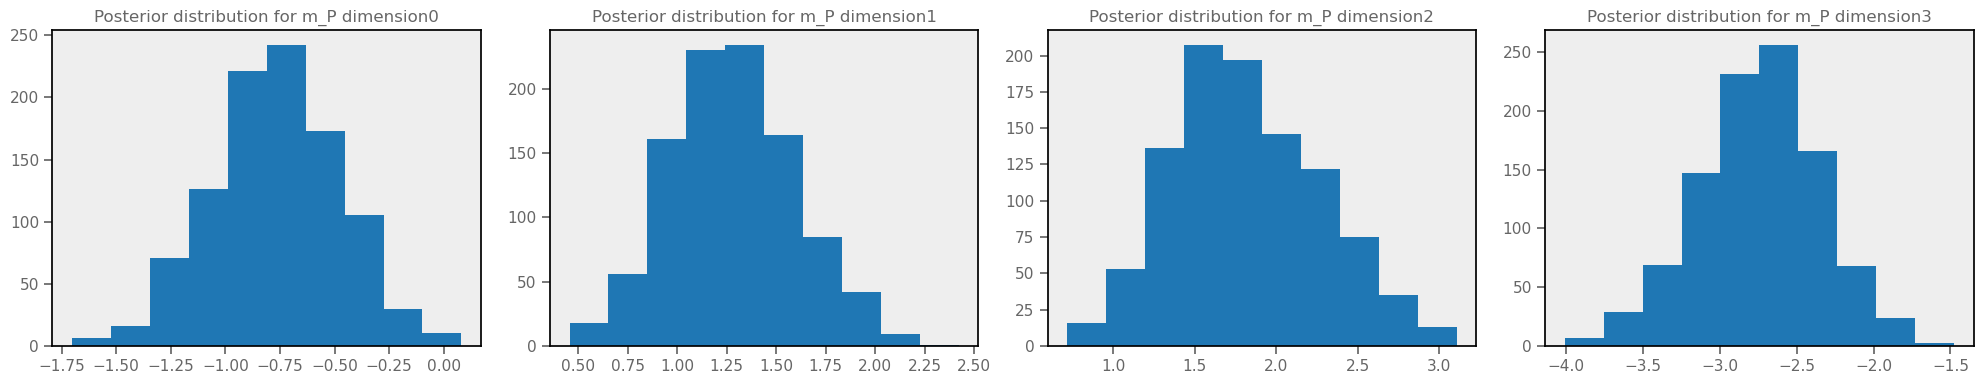

In [11]:
Y_train, X_train = torch.load("data_train.pt")
G, n, p = X_train.shape

hypers = {"L_0": torch.eye(p) * 1,
          "nu_0": 1.0,
          "tausq_0": 0.1,
          "alpha": torch.Tensor([5., 1.]),
          "mu_0": -5.0,
          "sigmasq_0": 2.0}

samples = gibbs(Y_train, X_train, hypers, n_samples=1000, n_burnin=1000, n_thin=5)

# YOUR CODE HERE (this should visualize posterior uncertainty over m_P).
import numpy as np
samples_mp = np.array([sample['m_P'].numpy() for sample in samples])
fig, axes = plt.subplots(1,p,figsize=(5*p,4))
for i in range(p):
    ax = axes[i]
    ax.hist(samples_mp[:,i])
    ax.set_title(f"Posterior distribution for m_P dimension{i}")
plt.tight_layout()
plt.show()

## **Problem 5**: Denoised group means [Code]
In this problem you are going to visualize the posterior uncertainty about the group-specific mean of non-anomalous responses---i.e.:
$$\bar{y}^\star_g \triangleq \frac{\sum_{i=1}^{n_g} y_{g,i} \, z_{g,i}}{\sum_{i=1}^{n_g} z_{g,i}} $$

If we knew $z_{g,i}$, we could compute this. However, our uncertainty about $z_{g,i}$ induces uncertainty about $\bar{y}^\star_g$---i.e., we are interested in the following posterior:

$$p(\bar{y}^\star_g \mid \mathbf{Y}, \mathbf{X})$$

For each group $g$, use your posterior samples to approximate and visualize uncertainty about $\bar{y}^\star_g$ under the posterior distribution. More specifically:
- Plot $G$ box-plots, each of which displays the **interquartile range** of $\bar{y}^\star_g$ under the posterior distribution.
- Each box-plot should also display the **posterior mean** of $\bar{y}^\star_g$ as a **red star**.
- The box-plots should all be in the same plot, with the group index $g$ on the x-axis, and a shared y-axis.
- For comparison, also plot the simple mean $\bar{y}_g = \tfrac{1}{n}\sum_{i=1}^n y_{g,i}$ as a **yellow diamond**.
- Ensure that all your axes are labeled and you have an informative legend.

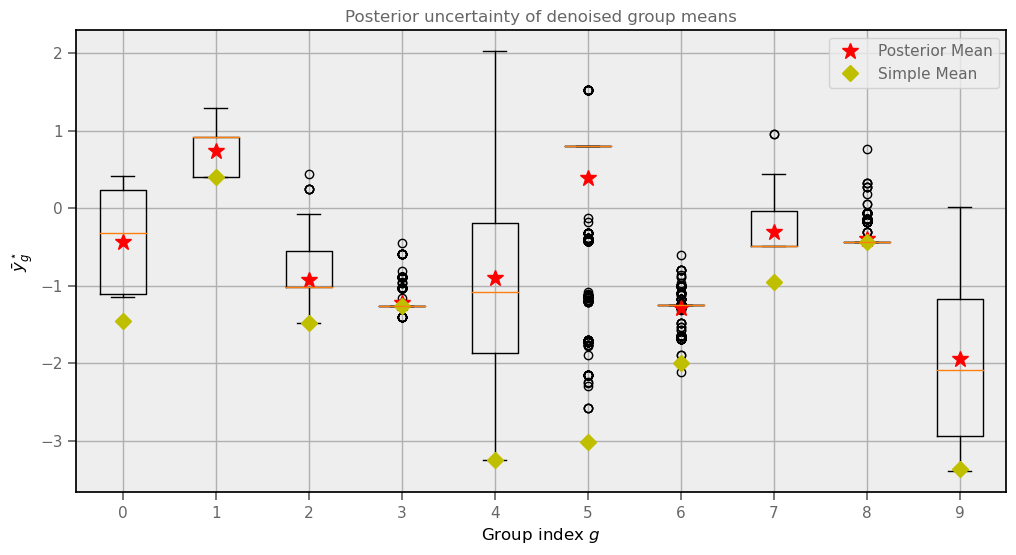

In [12]:
Y_train, X_train = torch.load("data_train.pt")
G, n, p = X_train.shape
y_star_samples = torch.zeros(len(samples),G)
for s, sample in enumerate(samples):
    Y_sample = Y_train
    Z_sample = sample['Z_GN']
    
    # Compute bar_y_star_g for each group
    numerator = (Y_sample * Z_sample).sum(dim=1)         
    denominator = Z_sample.sum(dim=1).clamp(min=1e-6)  
    y_star = numerator / denominator                  
    y_star_samples[s] = y_star

y_star_np = y_star_samples.numpy()

simple_means = Y_train.mean(dim=1).numpy()

fig, ax = plt.subplots(figsize=(12, 6))
box = ax.boxplot(y_star_np, positions=np.arange(G))
post_means = y_star_np.mean(axis=0)
ax.plot(np.arange(G), post_means, 'r*', label='Posterior Mean', markersize=12)
ax.plot(np.arange(G), simple_means, 'yD', label='Simple Mean', markersize=8)

ax.set_xlabel("Group index $g$")
ax.set_ylabel(r"$\bar{y}^\star_g$")
ax.set_title("Posterior uncertainty of denoised group means")
ax.legend()
ax.grid(True)

plt.show()


## **Problem 6**: Posterior predictive of $z_{g,i}$ [Math, code]
In this problem you are going to derive and implement a Monte Carlo approximation for the posterior predictive probability that a new unseen data point in group $g$ is not anomalous---i.e.:
$$p(z^{\textrm{test}}_{g, i} = 1\mid \mathbf{x}^{\textrm{test}}_{g, i}, \mathbf{Y}, \mathbf{X})$$

**6a):** First, provide the mathematical form of your Monte Carlo approximation, which should involve posterior samples of latent variables (e.g., using $\rho^m_{g}$ to denote the $m^{\textrm{th}}$ posterior sample of variable $\rho_{g}$).


---

$$p(z^{\textrm{test}}_{g, i} = 1\mid \mathbf{x}^{\textrm{test}}_{g, i}, \mathbf{Y}, \mathbf{X}) \approx \frac{1}{M}\sum_{m=1}^{M}p(z_{g,i}^{test}=1|\rho_g^m)$$

---

**6b):** Now implement your Monte Carlo estimator in the function `posterior_predictive_z`, and run the code so it prints out some test values.

In [13]:
Y_test, X_test = torch.load("data_test.pt")

def posterior_predictive_z_g(x, g, samples, hypers):
    """
    Compute the posterior predictive probability that a new unseen data point 
    in group g is not anomalous, i.e., p(z^{test}_{g, i} = 1 | x^{test}_{g, i}, Y, X).

    Args:
        x (torch.Tensor): Covariates for the new unseen data point.
        g (int): Group index for the new unseen data point.
        samples (list): List of posterior samples, where each sample is a state dictionary.
        hypers (dict): Dictionary of hyperparameters.

    NOTE: By default, we pass (x, g, samples, hypers), however this 
    may not require some of these inputs.

    Returns:
        torch.Tensor or float: Posterior predictive probability.
    """
    rho_samples = [sample['rho_G'][g].item() for sample in samples]
    return sum(rho_samples) / len(rho_samples)

# Print the posterior predictive for the first test data point in each group.
print([posterior_predictive_z_g(X_test[g, 0], g, samples, hypers) for g in range(G)])


[0.8061538819074631, 0.8991611349582672, 0.833187551677227, 0.929838042318821, 0.6111564102172852, 0.591028476729989, 0.816292101830244, 0.8485922618210315, 0.9322621656656265, 0.7228494470119476]


## **Problem 7**: Scaled pointwise predictive density [Math, code]
In this problem you are going to compute a Monte Carlo approximation to the **scaled pointwise predictive density (SPPD)** of the test data, defined as:

$$\textrm{SPPD} = \exp \left(\tfrac{1}{G \, n_{\textrm{test}}} \sum_{g=1}^G \sum_{i=1}^{n_{\textrm{test}}} \log p(y^{\textrm{test}}_{g,i} \mid \textbf{x}_{g,i}^{\textrm{test}}, \textbf{Y}^{\textrm{train}}, \textbf{X}^{\textrm{train}})\right)$$

where the term $\log p(y^{\textrm{test}}_{g,i} \mid \textbf{x}_{g,i}^{\textrm{test}}, \textbf{Y}^{\textrm{train}}, \textbf{X}^{\textrm{train}})$ is the (natural) log of the **posterior predictive density** of heldout test data point $(y^{\textrm{test}}_{g,i}, \textbf{x}_{g,i}^{\textrm{test}})$. 

SPPD is a measure of heldout predictive performance, which takes the geometric mean of the posterior predictive densities on the heldout test points. In this case, the same number of points $n_{\textrm{test}}$ have been heldout of each group $g$, making the total number of test points equal to $Gn_{\textrm{test}}$

In this problem, you will derive and implement a Monte Carlo approximation of SPPD which uses the posterior samples obtained during Gibbs sampling. 

**7a):** First, provide the mathematical form of your Monte Carlo approximation, which should involve posterior samples of latent variables (e.g., using $z^m_{g, i}$ to denote the $m^{\textrm{th}}$ posterior sample of variable $z_{g, i}$).


---

$$
\textrm{SPPD} \approx exp(\frac{1}{Gn_{test}}\sum_{g=1}^G\sum_{i=1}^{n_test}log(\frac{1}{M}\sum_{m=1}^M)[\rho_g^m\cdot N(y_{g,i}^{test}|x_{g,i}^{test}\cdot \beta_g^m,\sigma_g^{2(m)})+(1-\rho_g^m)\cdot N(y_{g,i}^{test}|\mu_0,\sigma_0^2)])
$$

---

**7b):** Now implement your Monte Carlo estimator. Your implementation should be numerically stable, and should compute everything in log-space, **using again the logsumexp trick**. You should **only** move out of log-space at the very end. After implementing `scaled_ppd`, run the code to print out the value of SPPD on the test data.

In [14]:
def scaled_ppd(Y, X, samples, hypers):
    """Computes the scaled pointwise predictive density (PPD) for the test data.

    Args:
        Y (torch.Tensor): Observed responses for the test data.
        X (torch.Tensor): Covariates for the test data.
        samples (list): List of posterior samples, where each sample is a state dictionary.
        hypers (dict): Dictionary of hyperparameters.

    Returns:
        torch.Tensor or float: The scaled pointwise predictive density.
    """
    G, n_test = Y.shape
    M = len(samples)

    sigmasq_0 = torch.tensor(hypers['sigmasq_0']).view(1, 1, 1).expand(M, G, n_test)
    mu_0 = torch.tensor(hypers['mu_0']).view(1, 1, 1).expand(M, G, n_test)

    beta_GP = torch.stack([s['beta_GP'] for s in samples])     # [M, G, P]
    rho_G = torch.stack([s['rho_G'] for s in samples])         # [M, G]
    sigmasq_G = torch.stack([s['sigmasq_G'] for s in samples],dim=0).squeeze().unsqueeze(-1).expand(-1, -1, Y.shape[1])

    X_expand = X.unsqueeze(0)                                  # [1, G, n_test, P]
    beta_expand = beta_GP.unsqueeze(2)                         # [M, G, 1, P]
    mu = (X_expand * beta_expand).sum(-1)                      # [M, G, n_test]

    Y_expand = Y.unsqueeze(0).expand(M, -1, -1)                                   # [1, G, n_test]

    # p(y | z=1)
    log_p_normal = -0.5 * torch.log(2 * torch.pi * sigmasq_G) \
                   - 0.5 * (Y_expand - mu)**2 / sigmasq_G      # [M, G, n_test]

    # p(y | z=0)
    log_p_anom = -0.5 * torch.log(2 * torch.pi * sigmasq_0) \
                 - 0.5 * (Y_expand - mu_0)**2 / sigmasq_0             # [1, G, n_test]

    rho = rho_G.unsqueeze(-1)

    stacked = torch.stack([
        torch.log(rho + 1e-8) + log_p_normal,
        torch.log(1 - rho + 1e-8) + log_p_anom
    ])  # shape: [2, M, G, n_test]

    log_marginals = torch.logsumexp(stacked, dim=0)            # [M, G, n_test]

    log_posterior_pred = torch.logsumexp(log_marginals, dim=0) - torch.log(torch.tensor(M, dtype=torch.float))  # [G, n_test]

    log_sppd = log_posterior_pred.mean()
    sppd = torch.exp(log_sppd)

    return sppd.item()

print(scaled_ppd(Y_test, X_test, samples, hypers))


0.22717292606830597


## Submission Instructions


**Formatting:** check that your code does not exceed 80 characters in line width. You can set _Tools &rarr; Settings &rarr; Editor &rarr; Vertical ruler column_ to 80 to see when you've exceeded the limit. 

Download your notebook in .ipynb format and use the following commands to convert it to PDF.  Then run the following command to convert to a PDF:
```
jupyter nbconvert --to pdf <yourlastname>_hw1.ipynb
```
(Note that for the above code to work, you need to rename your file `<yourlastname>_hw1.ipynb`)

Possible causes for errors:
  * the "Open in colab" button. Just delete the code that creates this button (go to the top cell and delete it)
  * Latex errors: many latex errors aren't visible in the notebook. Try binary search: comment out half of the latex at a time, until you find the bugs

Getting this HW into PDF form isn't meant to be a burden. One quick and easy approach is to open it as a Jupyter notebook, print, save to pdf. Just make sure your latex math answers aren't cut off so we can grade them.

Please post on Ed or come to OH if there are any other problems submitting the HW.

**Installing nbconvert:**

If you're using Anaconda for package management, 
```
conda install -c anaconda nbconvert
```

**Upload** your .pdf file to Gradescope. Please tag your questions!